# Комп'ютерний практикум №1. Варіант 102
## Моделі машинного навчання
## Мета:
Ознайомитись з принципами функціонування, створення, навчання та використання моделей
машинного навчання.
### Виконав:
студент групи ІС-34 Ткачов Костянтин

## Постановка задачі
За варіантом обрано датасет з характеристиками червоного вина, що містить 11 хімічних показників та його якість (Red Wine Quality). Розробляється модель на основі кластеризації для групування вин за характеристиками, що відносить вино до певної категорії, яку наприклад можна використати для маркування вин у магазині. Також за варіантом необхідно під час підготовки даних застосувати метод головних компонент (PCA) 2D.

# Виконання

In [77]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
import os

In [78]:
os.environ['OMP_NUM_THREADS'] = '4'
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL*")

# Підготовка даних

In [79]:
df = pd.read_csv('Red Wine Quality.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Очищення даних

In [80]:
df.corr().style.background_gradient(cmap='coolwarm')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


Зменшуємо кореляцію між ознаками,для цього об'єднуємо кислотності, видаляємо free sulfur dioxide, оскільки вже є сума діоксидів, а також прибираємо density.

In [81]:
df["total acid"] = df["fixed acidity"] + df["citric acid"]
df.drop(['free sulfur dioxide', 'density', 'fixed acidity', 'citric acid'], axis=1, inplace=True)
df.corr().style.background_gradient(cmap='coolwarm')

,volatile acidity,residual sugar,chlorides,total sulfur dioxide,pH,sulphates,alcohol,quality,total acid
volatile acidity,1.000000,0.001918,0.061298,0.076470,0.234937,-0.260987,-0.202288,-0.390558,-0.294847
residual sugar,0.001918,1.000000,0.055610,0.203028,-0.085652,0.005527,0.042075,0.013732,0.121335
chlorides,0.061298,0.055610,1.000000,0.047400,-0.265026,0.371260,-0.221141,-0.128907,0.108045
total sulfur dioxide,0.076470,0.203028,0.047400,1.000000,-0.066495,0.042947,-0.205654,-0.185100,-0.101272
pH,0.234937,-0.085652,-0.265026,-0.066495,1.000000,-0.196648,0.205633,-0.057731,-0.689584
sulphates,-0.260987,0.005527,0.371260,0.042947,-0.196648,1.000000,0.093595,0.251397,0.202162
alcohol,-0.202288,0.042075,-0.221141,-0.205654,0.205633,0.093595,1.000000,0.476166,-0.045785
quality,-0.390558,0.013732,-0.128907,-0.185100,-0.057731,0.251397,0.476166,1.000000,0.138527
total acid,-0.294847,0.121335,0.108045,-0.101272,-0.689584,0.202162,-0.045785,0.138527,1.000000


## Розподіл параметру якості

In [114]:
df['quality'].value_counts().sort_index()

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

Бачимо, що дані не збалансовані, більшість вин мають якість 5 або 6, що буде створювати труднощі для розрізнення вин з цими оцінками.

## Розбиття датасету

In [83]:
X = df
y = df['quality']

X_train = X.sample(frac=0.6, random_state=42)
X_test = X.drop(X_train.index)

## PCA 2D

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Вибір оптимального алгоритму кластеризації

Для нашої задачі кластеризації спробуємо кілька алгоритмів: KMeans, Gaussian Mixture Models (GMM), DBSCAN та Agglomerative Clustering. Оцінку якості кластеризації проведемо за допомогою метрик: Silhouette Score, Davies-Bouldin Index та Calinski-Harabasz Index.

#### Метрики якості кластеризації

In [85]:
df_train_metrics = pd.DataFrame({'Method': [], 'Silhouette': [], 'Davies-Bouldin': [], 'Calinski-Harabasz': []})
def add_metrics(method, clusters):
    silhouette = silhouette_score(X_train_pca, clusters) if len(set(clusters)) > 1 else -1
    davies_bouldin = davies_bouldin_score(X_train_pca, clusters) if len(set(clusters)) > 1 else np.inf
    calinski_harabasz = calinski_harabasz_score(X_train_pca, clusters) if len(set(clusters)) > 1 else -1
    global df_train_metrics
    df_train_metrics = pd.concat([df_train_metrics, pd.DataFrame({'Method': [method], 'Silhouette': [silhouette], 'Davies-Bouldin': [davies_bouldin], 'Calinski-Harabasz': [calinski_harabasz]})], ignore_index=True)

## КMeans

### Визначення оптимальної кількості кластерів за допомогою методу ліктя

In [86]:
k_values = range(2, 11)
inertias = []
iterations_list = []
decreases = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    inertias.append(kmeans.inertia_)
    iterations_list.append(kmeans.n_iter_)

    d = 0
    if len(inertias) > 1:
        d = (inertias[-2] - inertias[-1]) / inertias[-2] * 100
    decreases.append(d)

In [87]:
pct_changes = decreases[1:]
pct_diffs = [pct_changes[i] - pct_changes[i + 1] for i in range(len(pct_changes) - 1)]
print(f"Різниця між спадами: {[f'{diff:.2f}%' for diff in pct_diffs]}")

elbow_idx = np.argmax(pct_diffs) + 1
optimal_k = k_values[elbow_idx]
print(f"k оптимальний = {optimal_k}.")

Різниця між спадами: ['5.85%', '10.64%', '-3.87%', '0.97%', '6.50%', '-0.80%', '5.38%']
k оптимальний = 4.


### Застосування

In [88]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)

df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['Cluster'] = train_clusters

In [89]:
add_metrics('KMeans', train_clusters)

#### Розподіл показника якості по кластерах

In [90]:
pct = pd.crosstab(df_train['Cluster'], df_train['quality'], normalize='index') * 100
pct = pct.round(2)
pct.style.background_gradient(cmap='Blues', axis=1)

quality,3,4,5,6,7,8
Cluster,,,,,,
0,0.000000,5.880000,35.290000,52.160000,6.270000,0.390000
1,0.000000,0.710000,44.680000,44.680000,9.930000,0.000000
2,0.000000,0.000000,5.290000,46.150000,42.790000,5.770000
3,1.130000,4.510000,72.680000,21.690000,0.000000,0.000000


In [91]:
feature_cols = df_train.columns.difference(['Cluster'])
cluster_feature_means = df_train.groupby('Cluster')[feature_cols].mean()
cluster_sizes = df_train['Cluster'].value_counts().sort_index()
cluster_feature_means['Size'] = cluster_sizes
cluster_feature_means.style.background_gradient(cmap='viridis')

,alcohol,chlorides,pH,quality,residual sugar,sulphates,total acid,total sulfur dioxide,volatile acidity,Size
Cluster,,,,,,,,,,
0,10.816928,0.073969,3.467725,5.600000,2.238431,0.613451,6.927333,37.494118,0.596157,255
1,9.896927,0.132135,3.109929,5.638298,2.974468,0.792624,11.418156,44.560284,0.447128,141
2,11.433494,0.073702,3.273702,6.490385,2.404087,0.730385,9.290865,31.663462,0.357139,208
3,9.649202,0.086983,3.290901,5.149296,2.586620,0.585099,8.319831,61.616901,0.604915,355


#### Характеристика кластерів

In [92]:
median = df_train.groupby('Cluster')['quality'].median()
min_q = df_train.groupby('Cluster')['quality'].min()
max_q = df_train.groupby('Cluster')['quality'].max()
mean_q = df_train.groupby('Cluster')['quality'].mean()
quality_range = pd.DataFrame({'Min Quality': min_q, 'Max Quality': max_q, 'Median Quality': median, 'Mean Quality': mean_q})
quality_range

,Min Quality,Max Quality,Median Quality,Mean Quality
Cluster,,,,
0,4,8,6.0,5.600000
1,4,7,6.0,5.638298
2,5,8,6.0,6.490385
3,3,6,5.0,5.149296


| Кластер | Якість (середнє значення) | Характеристика                                                                                             | Інтерпретація стилю вина                                                                      |
| ------- |---------------------------| ---------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| **0**   | 5.6                       | Помірний алкоголь (\~10.8), високий pH (3.47), середня кислотність, помірна летка кислотність (\~0.6).     | Збалансовані **столові вина середньої якості**, придатні для щоденного вживання.              |
| **1**   | 5.63                      | Низький алкоголь (\~9.9), вищий рівень хлоридів і кислотності, помірний вміст сірки.                       | **Прості, легкі вина**, менш виражені, з відчутною солоністю та кислотністю.                  |
| **2**   | 6.49                      | Високий алкоголь (\~11.4), низька летка кислотність (\~0.36), гарна збалансованість параметрів.            | **Вина підвищеної якості (premium)**, з чистішим смаком, більш структуровані.                 |
| **3**   | 5.14                      | Низький алкоголь (\~9.6), дуже високий вміст SO₂ (\~61), середня кислотність, підвищена летка кислотність. | **Слабші вина**, з менш приємним профілем, ймовірно зберігають гірше, можуть мати різкі ноти. |


#### Візуалізація кластерів (PCA 2D) - Тренувальні дані - KMeans

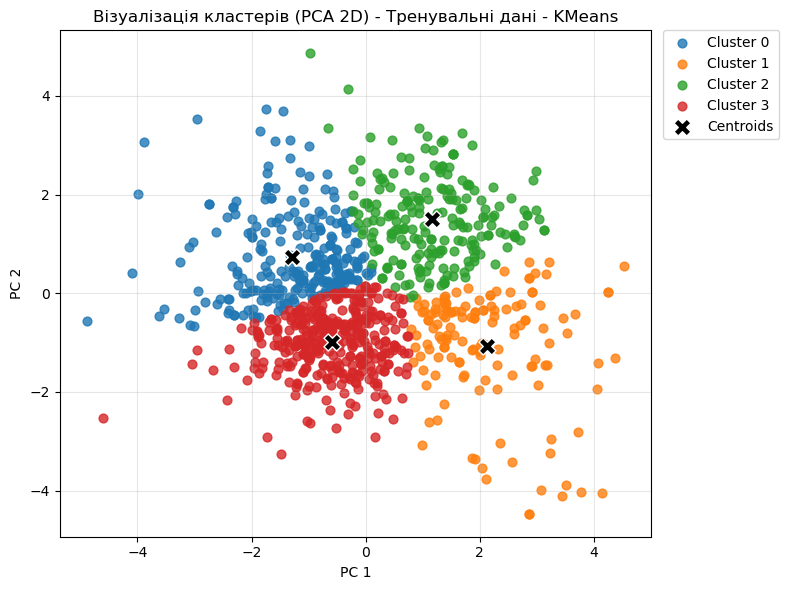

In [93]:
unique_labels = np.unique(train_clusters)
cmap = plt.get_cmap('tab10' if len(unique_labels) <= 10 else 'tab20')

plt.figure(figsize=(8, 6))
for i, lbl in enumerate(unique_labels):
    mask = train_clusters == lbl
    color = cmap(i % cmap.N)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
                c=[color], s=40, alpha=0.8, label=f'Cluster {lbl}')

if 'kmeans' in globals() and hasattr(kmeans, 'cluster_centers_'):
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Centroids', edgecolor='w')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Візуалізація кластерів (PCA 2D) - Тренувальні дані - KMeans')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## GMM

In [94]:
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm.fit(X_train_pca)
gmm_clusters = gmm.predict(X_train_pca)

df_gmm_train = pd.DataFrame(X_train, columns=X.columns)
df_gmm_train['Cluster'] = gmm_clusters

#### Розподіл показника якості по кластерах

In [95]:
pct = pd.crosstab(df_gmm_train['Cluster'], df_gmm_train['quality'], normalize='index') * 100
pct = pct.round(2)
pct.style.background_gradient(cmap='Blues', axis=1)

quality,3,4,5,6,7,8
Cluster,,,,,,
0,1.500000,8.000000,27.000000,51.500000,10.500000,1.500000
1,0.000000,0.880000,47.370000,42.980000,8.770000,0.000000
2,0.000000,0.000000,4.120000,45.880000,44.850000,5.150000
3,0.220000,3.330000,67.850000,28.380000,0.220000,0.000000


In [96]:
add_metrics('GMM', gmm_clusters)

### Візуалізація кластерів (PCA 2D) - Тестові дані - GMM

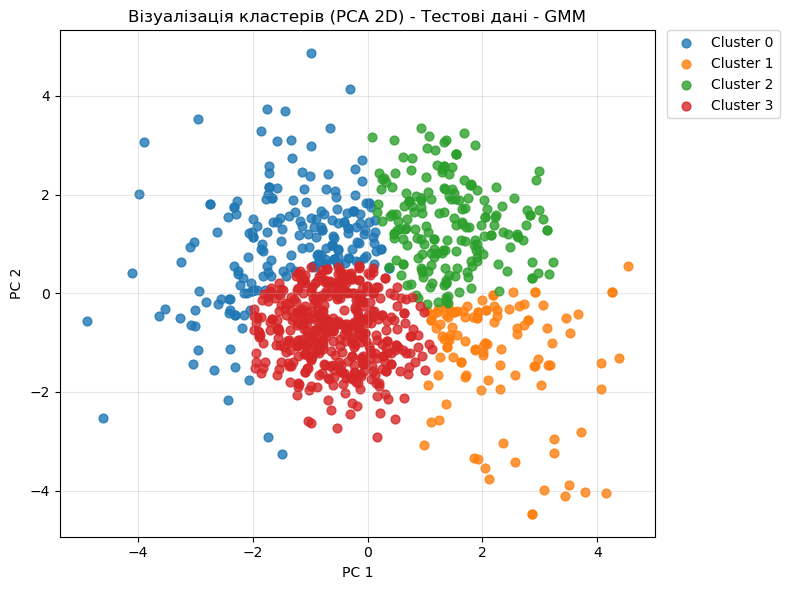

In [97]:
unique_labels = np.unique(gmm_clusters)
cmap = plt.get_cmap('tab10' if len(unique_labels) <= 10 else 'tab20')
plt.figure(figsize=(8, 6))
for i, lbl in enumerate(unique_labels):
    mask = gmm_clusters == lbl
    color = cmap(i % cmap.N)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
                c=[color], s=40, alpha=0.8, label=f'Cluster {lbl}')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Візуалізація кластерів (PCA 2D) - Тестові дані - GMM')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## DBSCAN

### Розрахунок оптимальних параметрів

In [98]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(X_train_pca)
distances, _ = nbrs.kneighbors(X_train_pca)
distances = np.sort(distances[:,2])

x = np.arange(len(distances))
y = distances

line_start = np.array([x[0], y[0]])
line_end = np.array([x[-1], y[-1]])

dist_to_line = np.abs((line_end[1]-line_start[1])*x - (line_end[0]-line_start[0])*y + line_end[0]*line_start[1] - line_end[1]*line_start[0])
dist_to_line /= np.sqrt((line_end[1]-line_start[1])**2 + (line_end[0]-line_start[0])**2)

knee_idx = np.argmax(dist_to_line)
optimal_eps = distances[knee_idx]

print(f"Optimal eps (knee method): {optimal_eps:.4f}")

optimal_min_samples = int(np.log(len(X_train)))
print(f"Optimal min_samples: {optimal_min_samples}")

Optimal eps (knee method): 0.3530
Optimal min_samples: 6


### Застосування

In [99]:
from numpy.linalg import inv
VI = inv(np.cov(X_train_pca, rowvar=False))
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples, metric='mahalanobis', metric_params={'VI': VI})
dbscan_clusters = dbscan.fit_predict(X_train_pca)
df_dbscan_train = pd.DataFrame(X_train, columns=X.columns)
df_dbscan_train['Cluster'] = dbscan_clusters

#### Розподіл показника якості по кластерах

In [100]:
pct = pd.crosstab(df_dbscan_train['Cluster'], df_dbscan_train['quality'], normalize='index') * 100
pct = pct.round(2)
pct.style.background_gradient(cmap='Blues', axis=1)

quality,3,4,5,6,7,8
Cluster,,,,,,
-1,5.880000,7.840000,41.180000,23.530000,15.690000,5.880000
0,0.110000,3.080000,44.160000,39.320000,12.220000,1.100000


In [101]:
counts = pd.crosstab(df_dbscan_train['Cluster'], df_dbscan_train['quality'])
counts

quality,3,4,5,6,7,8
Cluster,,,,,,
-1,3,4,21,12,8,3
0,1,28,401,357,111,10


In [102]:
add_metrics('DBSCAN', dbscan_clusters)

## AgglomerativeClustering

In [103]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=optimal_k, metric='mahalanobis', linkage='average')
agglo_clusters = agglomerative_clustering.fit_predict(X_train_pca)
df_agglo_train = pd.DataFrame(X_train, columns=X.columns)
df_agglo_train['Cluster'] = agglo_clusters

In [104]:
pct = pd.crosstab(df_agglo_train['Cluster'], df_agglo_train['quality'], normalize='index') * 100
pct = pct.round(2)
pct.style.background_gradient(cmap='Blues', axis=1)

quality,3,4,5,6,7,8
Cluster,,,,,,
0,0.330000,2.720000,44.340000,39.000000,12.530000,1.090000
1,8.330000,50.000000,25.000000,16.670000,0.000000,0.000000
2,0.000000,7.690000,0.000000,38.460000,30.770000,23.080000
3,0.000000,0.000000,75.000000,25.000000,0.000000,0.000000


In [105]:
feature_cols = df_agglo_train.columns.difference(['Cluster'])
cluster_feature_means = df_agglo_train.groupby('Cluster')[feature_cols].mean()
cluster_sizes = df_agglo_train['Cluster'].value_counts().sort_index()
cluster_feature_means['Size'] = cluster_sizes
cluster_feature_means.style.background_gradient(cmap='viridis')

,alcohol,chlorides,pH,quality,residual sugar,sulphates,total acid,total sulfur dioxide,volatile acidity,Size
Cluster,,,,,,,,,,
0,10.354847,0.083053,3.302190,5.639434,2.507734,0.647778,8.679074,45.774510,0.517985,918
1,11.075000,0.068250,3.605833,4.500000,2.316667,0.539167,6.503333,44.000000,1.063750,12
2,13.174359,0.054077,3.706154,6.615385,1.823077,0.726923,5.362308,59.384615,0.518462,13
3,9.218750,0.371062,3.069375,5.250000,3.431250,1.077500,9.208125,61.437500,0.567500,16


In [106]:
add_metrics('AgglomerativeClustering', agglo_clusters)

### Візуалізація кластерів (PCA 2D) - Тестові дані - AgglomerativeClustering

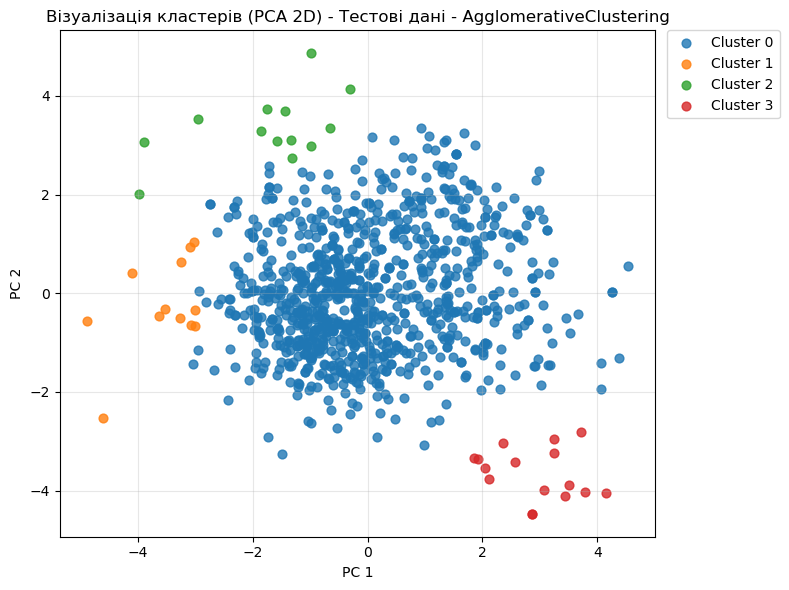

In [107]:
unique_labels = np.unique(agglo_clusters)
cmap = plt.get_cmap('tab10' if len(unique_labels) <= 10 else 'tab20')
plt.figure(figsize=(8, 6))
for i, lbl in enumerate(unique_labels):
    mask = agglo_clusters == lbl
    color = cmap(i % cmap.N)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1],
                c=[color], s=40, alpha=0.8, label=f'Cluster {lbl}')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Візуалізація кластерів (PCA 2D) - Тестові дані - AgglomerativeClustering')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Висновок вибору алгоритму

In [108]:
df_train_metrics.set_index('Method')
df_train_metrics.style.background_gradient(cmap='viridis')

,Method,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.350352,0.939010,635.449504
1,GMM,0.351486,1.009771,555.584051
2,DBSCAN,0.446626,4.527002,17.997411
3,AgglomerativeClustering,0.240706,0.672909,68.742050


Порівнючи кластеризацію KMeans, GMM та DBSCAN, AgglomerativeClustering, оберемо KMeans як найкращий алгоритм для цього завдання. GMM має проблему з тим, що межі класетерів розмитті, у DBSCAN багато шуму та при підборі різних параметрів, всеодно не виходить розбити на кластери (алгоритм видає один кластер + шум). AgglomerativeClustering має найгіршу схожість елементів всередині кластерів(видно по метриці Silhouette), але кластери краще розділені(метрика Davies-Bouldin), але в результаті кластеризації виходить 1 великий кластер та 3 маленьких, що не дуже добре для нашої задачі (видно по візуалізації та метриці Calinski-Harabasz).

# Застосування моделі

In [109]:
test_clusters = kmeans.predict(X_test_pca)
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['Cluster'] = test_clusters

### Характеристика кластерів на тестовій вибірці

#### Розподіл показника якості по кластерах

In [110]:
ptc = pd.crosstab(df_test['Cluster'], df_test['quality'], normalize='index') * 100
ptc = ptc.round(2)
ptc.style.background_gradient(cmap='Blues', axis=1)

quality,3,4,5,6,7,8
Cluster,,,,,,
0,0.000000,2.330000,25.580000,65.700000,6.400000,0.000000
1,0.000000,2.630000,43.420000,47.370000,5.260000,1.320000
2,0.000000,0.000000,3.800000,52.530000,41.140000,2.530000
3,2.560000,6.410000,75.210000,15.810000,0.000000,0.000000


#### Середні значення ознак по кластерах

In [111]:
feature_cols = df_test.columns.difference(['Cluster'])
cluster_feature_means = df_test.groupby('Cluster')[feature_cols].mean()
cluster_sizes = df_test['Cluster'].value_counts().sort_index()
cluster_feature_means['Size'] = cluster_sizes
cluster_feature_means.style.background_gradient(cmap='viridis')

,alcohol,chlorides,pH,quality,residual sugar,sulphates,total acid,total sulfur dioxide,volatile acidity,Size
Cluster,,,,,,,,,,
0,10.820058,0.074186,3.459477,5.761628,2.272965,0.625872,6.991570,37.122093,0.581424,172
1,10.194737,0.134526,3.122895,5.592105,3.043421,0.868816,11.148421,51.684211,0.445526,76
2,11.416456,0.078835,3.275253,6.424051,2.607278,0.730949,9.488671,30.911392,0.381108,158
3,9.697792,0.088534,3.301880,5.042735,2.636111,0.578590,8.225983,63.252137,0.623120,234


| Кластер | Якість (середнє значення) | Характеристика                                                                                             | Інтерпретація стилю вина                                                                      |
| ------- |---------------------------| ---------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| **0**   | 5.6                       | Помірний алкоголь (\~10.8), високий pH (3.47), середня кислотність, помірна летка кислотність (\~0.6).     | Збалансовані **столові вина середньої якості**, придатні для щоденного вживання.              |
| **1**   | 5.63                      | Низький алкоголь (\~9.9), вищий рівень хлоридів і кислотності, помірний вміст сірки.                       | **Прості, легкі вина**, менш виражені, з відчутною солоністю та кислотністю.                  |
| **2**   | 6.49                      | Високий алкоголь (\~11.4), низька летка кислотність (\~0.36), гарна збалансованість параметрів.            | **Вина підвищеної якості (premium)**, з чистішим смаком, більш структуровані.                 |
| **3**   | 5.14                      | Низький алкоголь (\~9.6), дуже високий вміст SO₂ (\~61), середня кислотність, підвищена летка кислотність. | **Слабші вина**, з менш приємним профілем, ймовірно зберігають гірше, можуть мати різкі ноти. |


### Оцінка якості кластеризації на тестовій вибірці

In [112]:
print("Silhouette Score:", silhouette_score(X_test_pca, test_clusters))
print("Davies-Bouldin Index:", davies_bouldin_score(X_test_pca, test_clusters))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_test_pca, test_clusters))

Silhouette Score: 0.34874824972072954
Davies-Bouldin Index: 0.9611255265189272
Calinski-Harabasz Index: 394.89639359687385


#### Візуалізація кластерів на тестовій вибірці(PCA 2D)

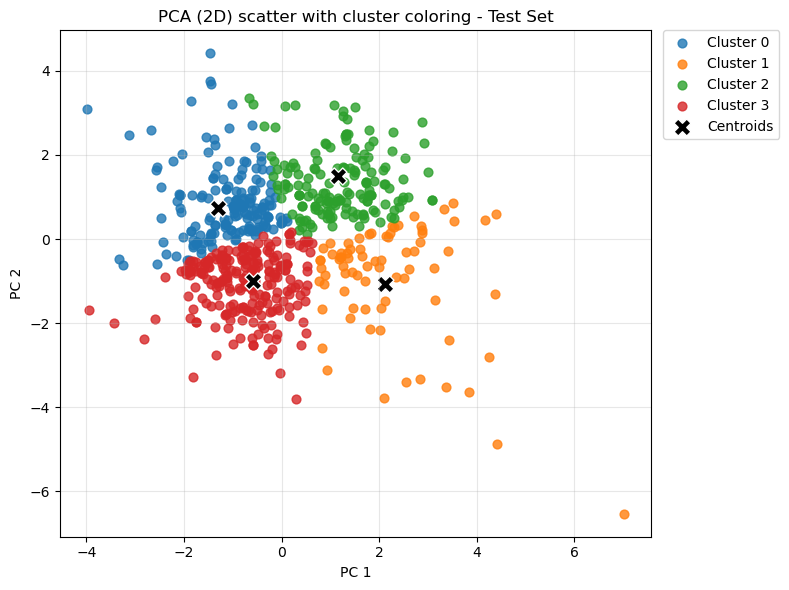

In [113]:
unique_labels = np.unique(test_clusters)
cmap = plt.get_cmap('tab10' if len(unique_labels) <= 10 else 'tab20')

plt.figure(figsize=(8, 6))
for i, lbl in enumerate(unique_labels):
    mask = test_clusters == lbl
    color = cmap(i % cmap.N)
    marker = 'x' if lbl == -1 else 'o'   # handle possible noise label (DBSCAN)
    plt.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1],
                c=[color], marker=marker, s=40, alpha=0.8, label=f'Cluster {lbl}')

if 'kmeans' in globals() and hasattr(kmeans, 'cluster_centers_'):
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Centroids', edgecolor='w')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA (2D) scatter with cluster coloring - Test Set')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Висновки
У ході виконання комп'ютерного практикуму було реалізовано модель кластеризації для групування червоного вина за його хімічними характеристиками. Було проведено очищення даних, зменшення кореляції між ознаками, зменшення розімрності даних за допомогою PCA до 2D. Було розглянуто кілька алгоритмів кластеризації, серед яких KMeans, GMM, DBSCAN та AgglomerativeClustering. Порівняння алгоритмів за допомогою метрик якості кластеризації показало, що KMeans є найкращим вибором для цієї задачі. Модель спочатку було навченна на тестових данних, а потім була застосована до тестової вибірки. Отримані кластери мають чіткі характеристики, що дозволяє інтерпретувати стиль вина в кожному кластері.